## **MANSI KAKKAR (EE21S063)**

# **PROGRAMMING ASSIGNMENT 2 OF DEEP LEARNING FOR IMAGING (EE5179)**

___
___
### **Comprises of three sections** : 
- *MNIST classification using CNN*
  * With the architecture as: 
    * A convolution layer with 32 3x3 filters with stride 1 and padding 1
    * A 2x2 maxpool layer with stride 2
    * A convolution layer with 32 3x3 filters with stride 1 and padding 1
    * A 2x2 maxpool layer with stride 2
    * A fully connected layer with 500 outputs
    * A fully connected layer with 10 outputs
  * Training the network for 8 epochs with learning rate = 0.01


- *Visualising the Convolutional layers*
  * Visualising both the convolutional layers along with one fully connected layer as well
  * Visualising the output of layers after each convolutional layer
  * Visualising Occlusion effects on test images


- *Adversarial Examples*
  * Non - Targetted Attack
  * Targetted Attack
  * Adding Noise

## Importing Libraries

In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid

torch.manual_seed(2111)

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

In [3]:
#Setting the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Intialisation

In [24]:
epochs = 8
learning_rate = 0.01
batch_size = 100
momentum = 0.9
indices = [10, 2, 1, 63, 65, 15, 66, 60, 61, 62]
non_targetted_n = 15000
targetted_n = 5000
non_targetted_step_size = 0.01
beta = 0.001
alpha = 0.1

## Loading Dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])
train_dataset = datasets.MNIST(root = "data/", train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = "data/", train = False, transform = transform, download = True)

print(f"number of train samples: {len(train_dataset)}")
print(f"number of test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

number of train samples: 60000
number of test samples: 10000


In [6]:
print(f"size of train dataloader is :{len(train_loader)}")
print(f"size of test dataloader is :{len(test_loader)}")
data = next(iter(train_loader))
img, target = data
target
print(f"image shape:{img.shape}")
print(f"Targets shape:{target.shape}")

size of train dataloader is :600
size of test dataloader is :100
image shape:torch.Size([100, 1, 28, 28])
Targets shape:torch.Size([100])


# **MNIST CLASSIFICATION USING CNN**

# CNN Model

* $log(softmax)$ is used here instead of $softmax$
* Forward function returns output with the condition, whether the output needs softmax output or not.

In [7]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.activ = nn.ReLU()
    
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1)
    self.layer1 = nn.Sequential(self.conv1, self.activ, nn.MaxPool2d(kernel_size = 2, stride = 2))
    
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1)
    self.layer2 = nn.Sequential(self.conv2, self.activ, nn.MaxPool2d(kernel_size = 2, stride = 2))
    
    self.fc1 = nn.Linear(32*7*7, 500)
    self.layer3 = nn.Sequential(self.fc1, self.activ)
    
    self.layer4 = nn.Linear(500, 10)

  # def pool(self, x, kernel = 2, stride = 2):
    # out = F.max_pool2d(x, kernel_size = kernel, stride = stride)
    # return out

  def forward(self, x, softmax = True):
    out = self.layer1(x.float())
    out = self.layer2(out)

    out = out.view(out.size(0),-1)
    out = self.layer3(out)
    out = self.layer4(out)
    if softmax:
      return F.log_softmax(out, dim = 1)
    else:
      return out


# Training

* Used nll loss here
* Returns training loss

In [8]:
def train_model(model, data_loader, optimizer, epoch, device, out_dir = "out/"):
  model.train()
  train_loss = []
  print('For Train Dataset:\n')
  for index, (image, target) in enumerate(data_loader):
    image, target = image.to(device), target.to(device)
    optimizer.zero_grad()
    out = model(image)
    loss = F.nll_loss(out, target)
    loss.backward()
    optimizer.step()
  train_loss.append(loss.item())
  print('Epoch: {}[{}/{} ({}%)], Train Loss:{:.06f}\n'.format(epoch, index*len(image), len(data_loader.dataset), 100.0*index/len(data_loader), loss.item()))

  return train_loss

# Testing

* Returns predicted values, test/validation loss and accuracy

In [9]:
def test_model(model, data_loader, epoch, device, out_dir="out/"):
  #Testing
    model.eval()
    correct = 0
    loss = 0
    prediction = []
    print('For Test Dataset:\n')
    with torch.no_grad():
      for index, (image, target) in enumerate(data_loader):
        image = image.to(device)
        target = target.to(device)
        out = model(image)
        loss+= F.nll_loss(out, target, reduction = "sum").item()
        predicted = out.argmax(dim=1, keepdim = True)
        correct += predicted.eq(target.view_as(predicted)).sum().item()
        prediction.append(predicted)
    loss/= len(test_loader.dataset)
    acc = correct/(len(test_loader.dataset))
    print('Epoch:{} [{}/{} ({}%)] , Test Loss:{:.4f}, Test Accuracy:{}%\n'.format(epoch,index*len(image), len(data_loader.dataset), 100.0*index/len(data_loader), loss, 100.0*acc))
    

    return prediction, loss, acc


# Main Function

* Stochastic Gradient Descent is used as the optimiser
* Validation losses, Accuracies are stored 
* Graph for Train and Validation loss, and Accuracies has been plotted in the later stages

In [10]:
train_losses = []
validation_losses = []
validation_accuracies = []
predicted = []
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
for epoch in range(epochs):
  #calling Train Model
  train_loss = train_model(model, train_loader, optimizer, epoch, device)
  #calling Test Model
  predicted, validation_loss, validation_acc = test_model(model, test_loader, epoch, device)

  train_losses.append(train_loss)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_acc)







For Train Dataset:

Epoch: 0[59900/60000 (99.83333333333333%)], Train Loss:0.253941

For Test Dataset:

Epoch:0 [9900/10000 (99.0%)] , Test Loss:0.2527, Test Accuracy:92.74%

For Train Dataset:

Epoch: 1[59900/60000 (99.83333333333333%)], Train Loss:0.105856

For Test Dataset:

Epoch:1 [9900/10000 (99.0%)] , Test Loss:0.1518, Test Accuracy:95.57%

For Train Dataset:

Epoch: 2[59900/60000 (99.83333333333333%)], Train Loss:0.089902

For Test Dataset:

Epoch:2 [9900/10000 (99.0%)] , Test Loss:0.1136, Test Accuracy:96.75%

For Train Dataset:

Epoch: 3[59900/60000 (99.83333333333333%)], Train Loss:0.071108

For Test Dataset:

Epoch:3 [9900/10000 (99.0%)] , Test Loss:0.0818, Test Accuracy:97.56%

For Train Dataset:

Epoch: 4[59900/60000 (99.83333333333333%)], Train Loss:0.070827

For Test Dataset:

Epoch:4 [9900/10000 (99.0%)] , Test Loss:0.0738, Test Accuracy:97.74000000000001%

For Train Dataset:

Epoch: 5[59900/60000 (99.83333333333333%)], Train Loss:0.066107

For Test Dataset:

Epoch:5 [

In [11]:
image, correct = next(iter(test_loader))


# Visualising the outputs
Correct class labels along with the predicted class labels corresponding to the images of all the numbers from 0 to 9 have been plotted to show the results

torch.Size([100, 1, 28, 28])
torch.Size([100])
100
Index is: 0 	 Correct: 0 	 Predicted: tensor([0])



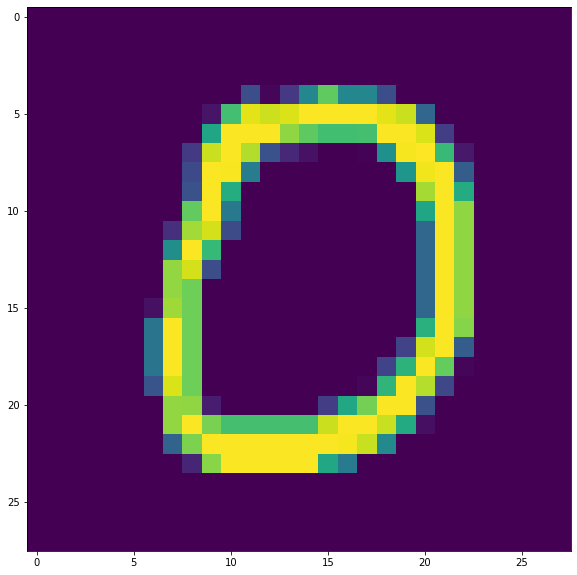

Index is: 1 	 Correct: 1 	 Predicted: tensor([1])



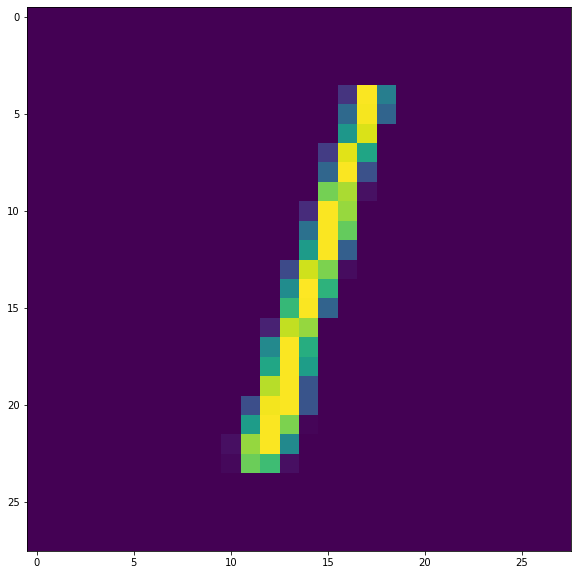

Index is: 2 	 Correct: 2 	 Predicted: tensor([2])



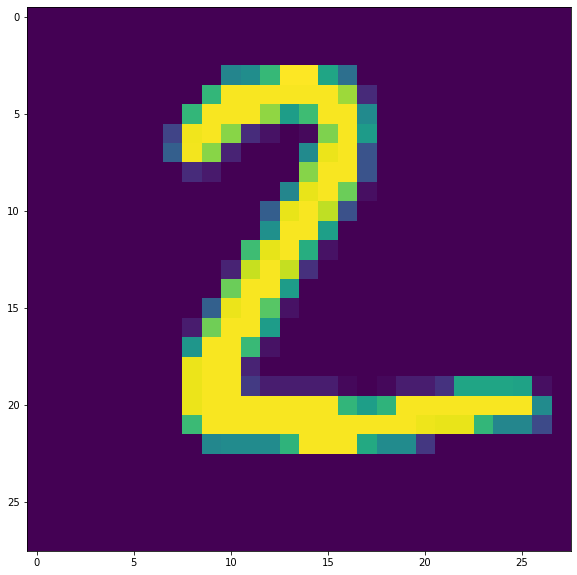

Index is: 3 	 Correct: 3 	 Predicted: tensor([3])



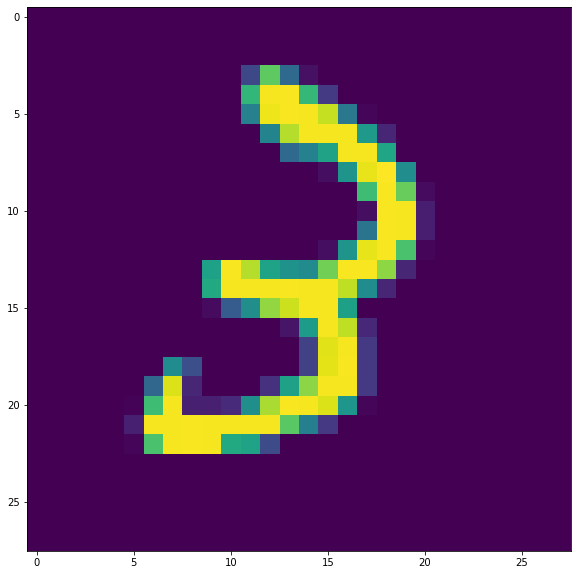

Index is: 4 	 Correct: 4 	 Predicted: tensor([4])



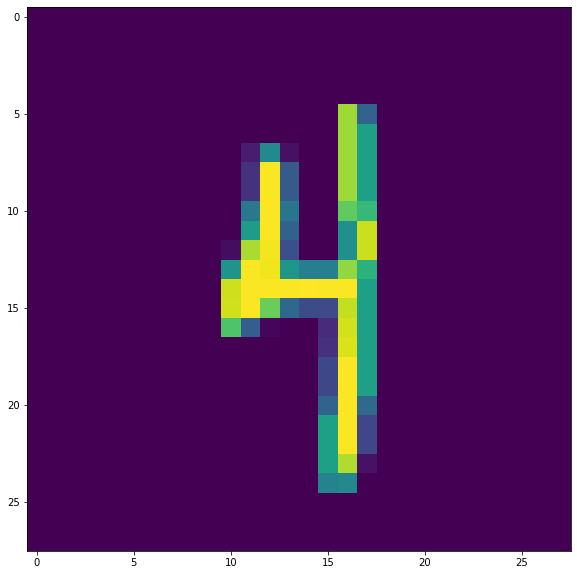

Index is: 5 	 Correct: 5 	 Predicted: tensor([5])



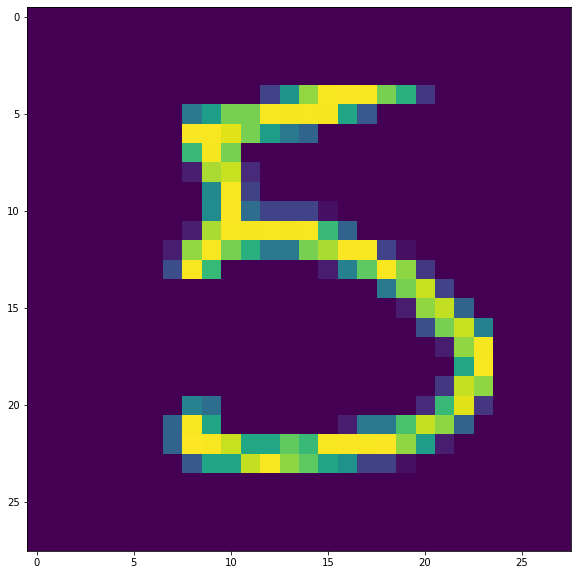

Index is: 6 	 Correct: 6 	 Predicted: tensor([6])



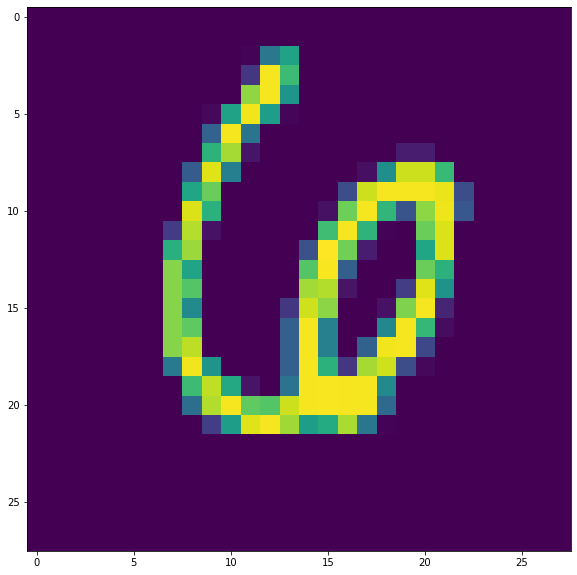

Index is: 7 	 Correct: 7 	 Predicted: tensor([7])



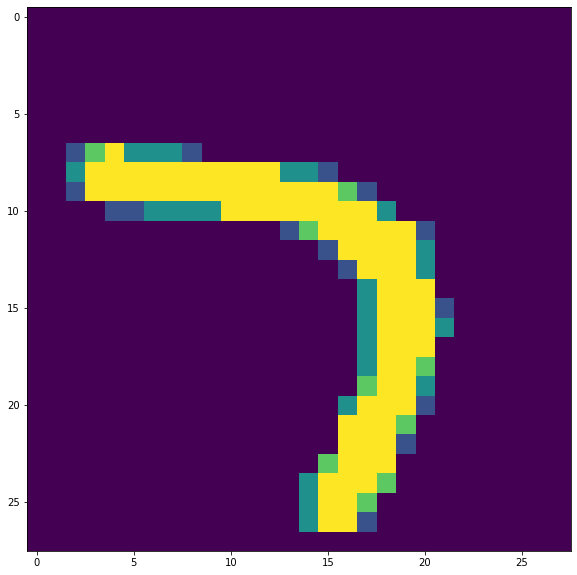

Index is: 8 	 Correct: 8 	 Predicted: tensor([8])



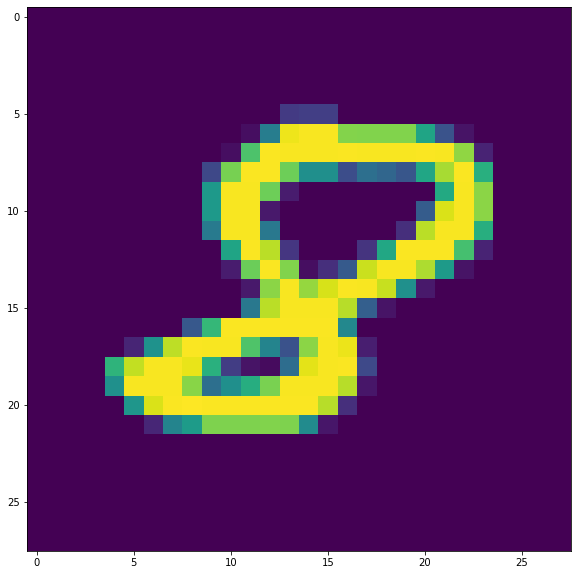

Index is: 9 	 Correct: 9 	 Predicted: tensor([9])



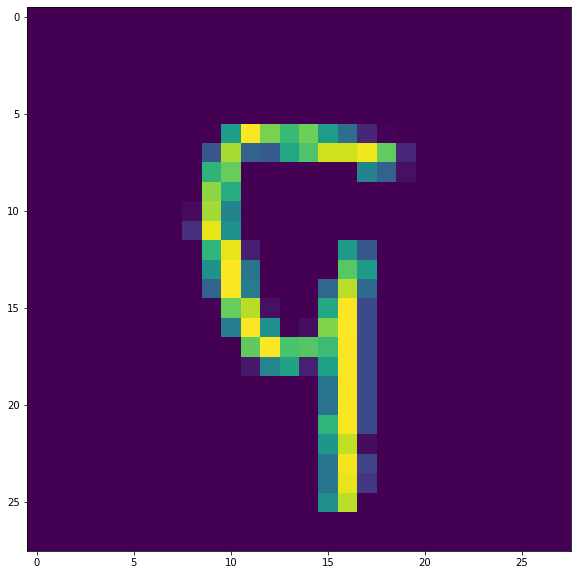

In [12]:
print(image.shape)
print(correct.shape)
print(len(predicted))
for i in range(10):
  print("Index is: {} \t Correct: {} \t Predicted: {}\n".format(i, correct[indices[i]], predicted[0][indices[i]]))
  plt.imshow(image[indices[i]].reshape(28,28).cpu())
  plt.show()

# Plot Loss Graphs and Accuracy

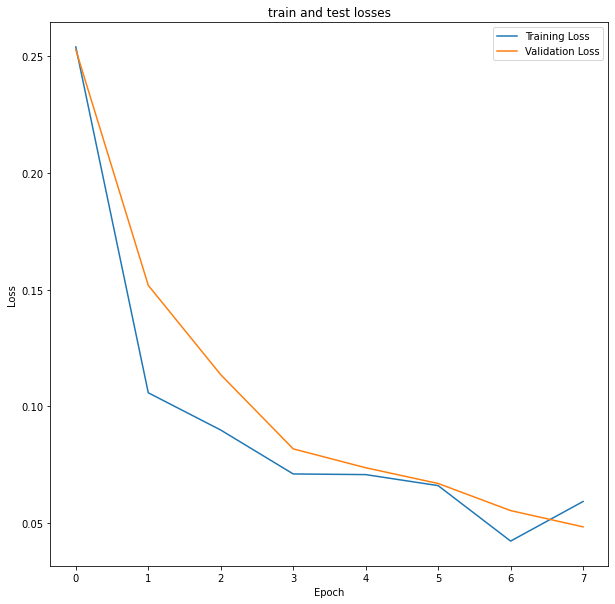

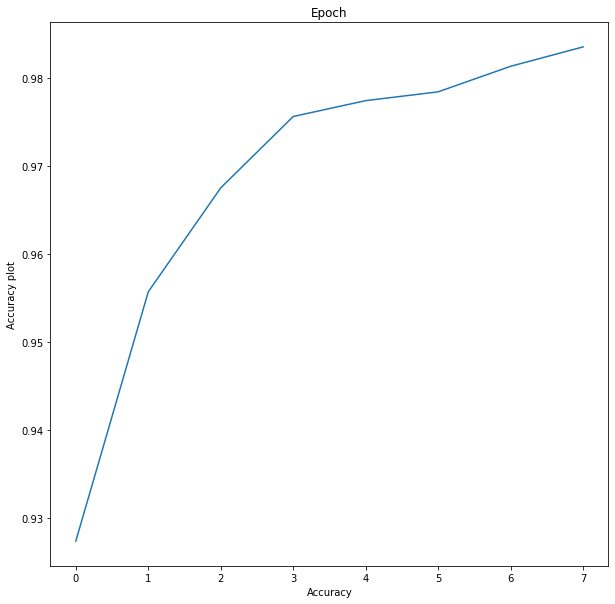

In [13]:
#plot 
plt.plot(np.asfarray(train_losses)[::int(len(train_losses)/epochs)])
plt.plot(np.asfarray(validation_losses))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train and test losses')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

#plot Accuracies
plt.plot(np.asfarray(validation_accuracies))
plt.xlabel('Accuracy')
plt.ylabel('Accuracy plot')
plt.title('Epoch')
plt.show()

# Average Prediction Accuracy

In [14]:
#Average prediction accuracy
acc = np.mean(np.asarray(validation_accuracies))
print(f'Average prediction Accuracy is:{acc*100}%')

Average prediction Accuracy is:96.83500000000001%


# Taking Random Images and plotting them

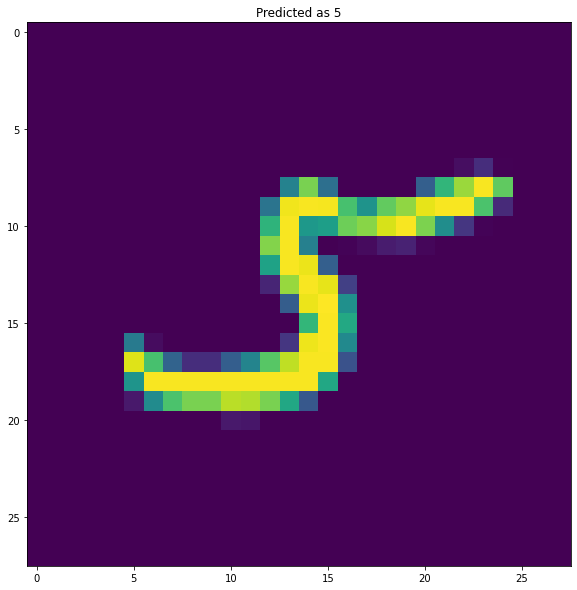

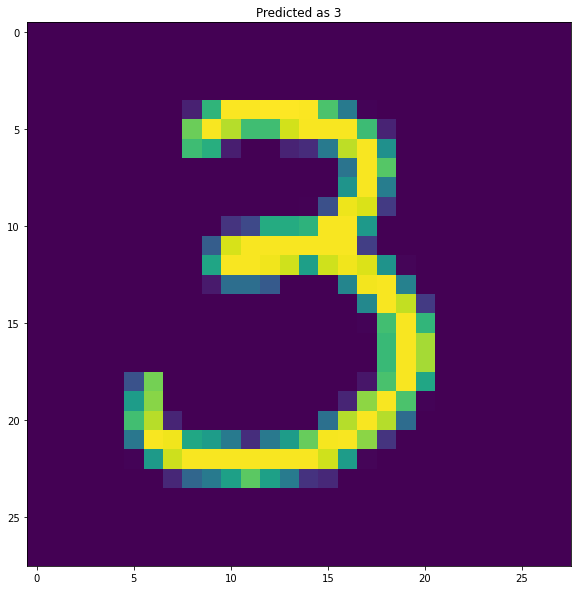

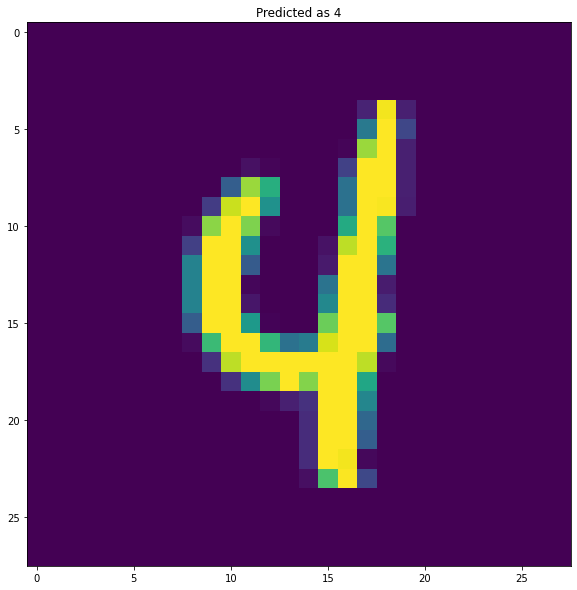

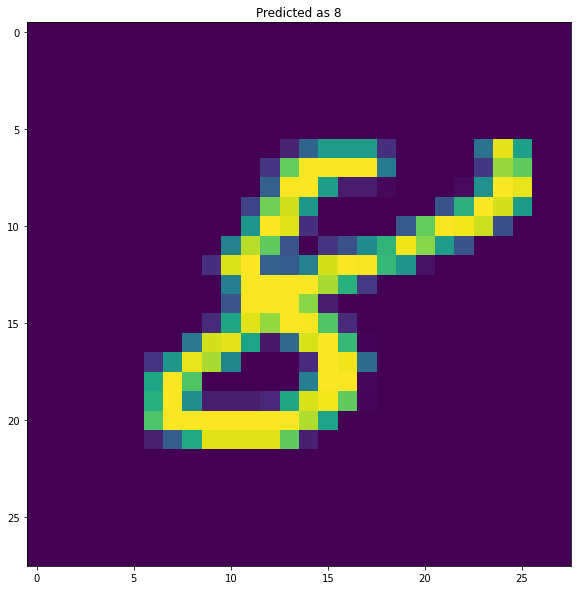

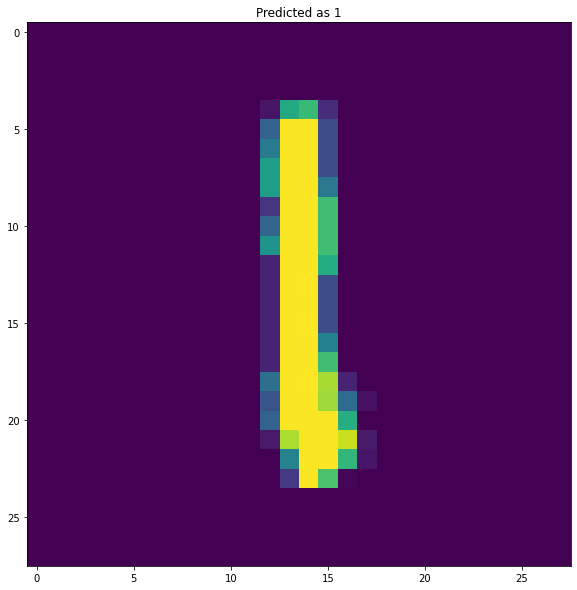

In [15]:
rand_index = np.random.randint(low = 0, high = 9999, size = 5)
for idx in rand_index:
  img = test_loader.dataset.data[idx, :, :].clone()
  with torch.no_grad():
    if device==torch.device("cuda"):
      img = img.reshape(1,1,28,28).cuda().float()
    else:
      img = img.reshape(1,1,28,28).float()
    out = model.forward(img).detach().cpu().numpy()
  pred = np.argmax(out)
  plt.imshow(img.detach().cpu().numpy().reshape(28,28))
  plt.title(f'Predicted as {pred}')
  plt.show()

# Dimensions of Input and Output of each layer
  - Layer 1
    
    **After Convolution**
    * Input - 28 X 28 
    * Output - 28 X 28 X 32

    **After Maxpool**
    * Input - 28 X 28 X 32
    * Ouput - 14 X 14 X 32
  
  - Layer 2

    **After Convolution**
    * Input - 14 X 14 X 32 
    * Output - 14 X 14 X 32

    **After Maxpool**
    * Input - 14 X 14 X 32
    * Ouput - 7 X 7 X 32

  - Layer 3

    **Fully Connected Layer**
    * Input - 7 X 7 X 32
    * Ouput - 500

  - Layer 4

    **Fully Connected Layer**
    * Input - 500
    * Ouput - 10

# Parameters

  - Layer 1

    **Convolutional layer 1**
    * Weights = 3 X 3 X 28 = 288
    * Biases = 32
    * Total = 320

    **Weights for Pooling Layer is 0**

  - Layer 2

    **Convolutional layer 2**
    * Weights = 32 X 3 X 3 X 32 = 9216
    * Biases = 32
    * Total = 9248

    **Weights for Pooling Layer is 0**
  
  - Layer 3

    **Fully Connected Layer 1**
    * Weights = 7 X 7 X 32 X 500 = 784000
    * Biases = 500
    * Total = 784500
  
  - Layer 4

    **Fully Connected Layer 2**
    * Weights = 500 X 10 = 5000
    * Biases = 10
    * Total = 5010

So, Total number of parameters = 799078

# Number of Neurons

- Layer 1
  * 1 X 3 X 3 X 32 = 288
- Layer 2
  * 3 X 3 X 3 X 32 = 9216
- Layer 3
  * 500
- Layer 4
  * 10
  
So, total number of neurons are = 9564


# Batch Normalisation 
- Batch normalisation shows almost same effects as the model without batch normalisation, not much change in accuracy




____

# **VISUALISING THE MODEL**


# Plot Kernels

Visualising kernel 1

* Convolutional layer 1
___

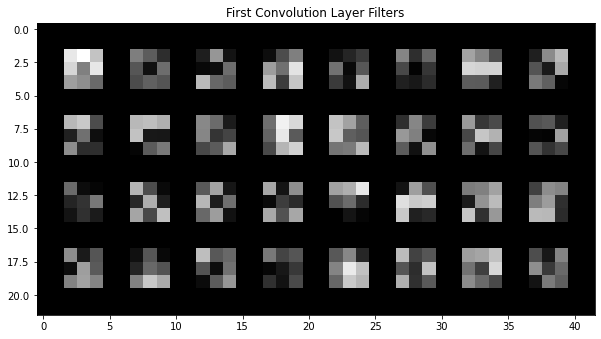

In [16]:
kernel1 = model.conv1.weight.detach().clone()
kernel1 = kernel1.cpu()
kernel1 = kernel1-kernel1.min()
kernel1 = kernel1/kernel1.max()
img1 = make_grid(kernel1)
plt.imshow(img1.permute(1,2,0))
plt.title("First Convolution Layer Filters")
plt.show()

Visualising Kernel 2

* Convolutional Layer 2
___




Choose the filter number between 0 and 31 which you want to visualize.
3
shape of the image is torch.Size([3, 22, 42])


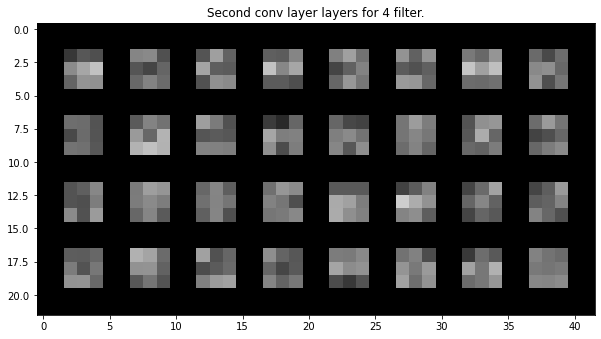

In [17]:
kernel2 = model.conv2.weight.detach().clone()
kernel2 = kernel2.cpu()
kernel2 = kernel2 - kernel2.min()
kernel2 = kernel2/kernel2.max()
filter_number = int(input("\nChoose the filter number between 0 and 31 which you want to visualize.\n"))
temp_kernel = kernel2[filter_number, :, :, :].reshape(32, 1, 3, 3)
img = make_grid(temp_kernel)
print(f'shape of the image is {img.shape}')
plt.imshow(img.permute(1, 2, 0))
to_show = int(filter_number)+1
plt.title(f"Second conv layer layers for {to_show} filter.")
plt.show()

Visualising kernel 3

* Fully Connected layer 1
___

shape of the image is torch.Size([3, 500, 1568])


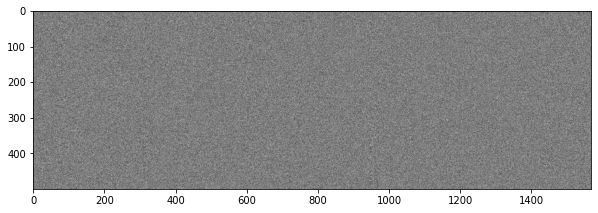

In [18]:
kernel3 = model.fc1.weight.detach().clone()
kernel3 = kernel3.cpu()
kernel3 = kernel3 - kernel3.min()
kernel3 = kernel3/kernel3.max()
img = make_grid(kernel3)
print(f'shape of the image is {img.shape}')
plt.imshow(img.permute(1, 2, 0))

## *Observations:*

* Convolutional kernel 1 is more sharp whereas Convolutional kernel 2 is more smoothened. 
* In convolutional kernel we can white and black patches in grids whereas in Convolutional kernel 2 we can observe grey patches in all grids 

# Visualising Features


Choose the number for which you want to visualise feature map and occlusion effects	4


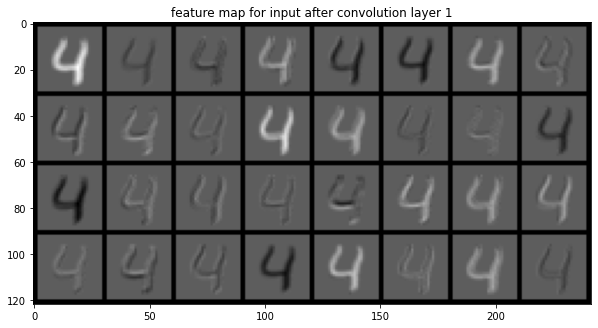

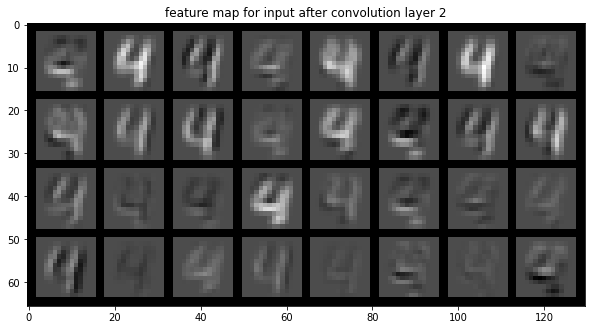

In [19]:
index = int(input("\nChoose the number for which you want to visualise feature map and occlusion effects\t"))
test_img = test_loader.dataset.data[[index], :, :].clone()

if (device == torch.device("cuda")):
  test_image = test_img.reshape(1,1,28,28).clone().cuda().float()
else:
  test_image = test_img.reshape(1,1,28,28).clone().float()
with torch.no_grad():
  out_1 = model.layer1[0].forward(test_image).reshape(32,1,28,28)
  out_1 = out_1.cpu()
  out_1 = out_1 - out_1.min()
  out_1 = out_1/out_1.max()
  img = make_grid(out_1)
  plt.imshow(img.permute(1,2,0))
  plt.title("feature map for input after convolution layer 1")
  plt.show()

out_2 = model.layer1.forward(test_image)
out_2 = model.layer2[0].forward(out_2)
out_2 = out_2.cpu()
out_2 = out_2 - out_2.min()
out_2 = out_2/out_2.max()
out_2 = out_2.reshape(32,1,14,14)
img = make_grid(out_2)
plt.imshow(img.permute(1,2,0))
plt.title("feature map for input after convolution layer 2")
plt.show()


## *Observations:*

Ouput of Convolutional layer 1 shows proper feature extraction

## Visualising Occluding parts of the Image

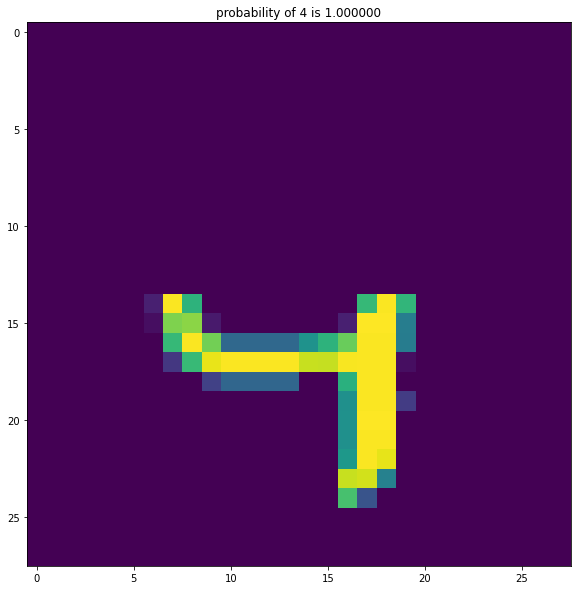

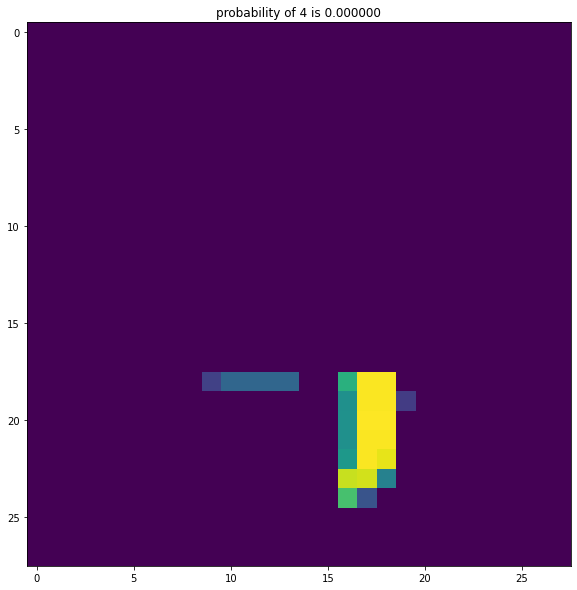

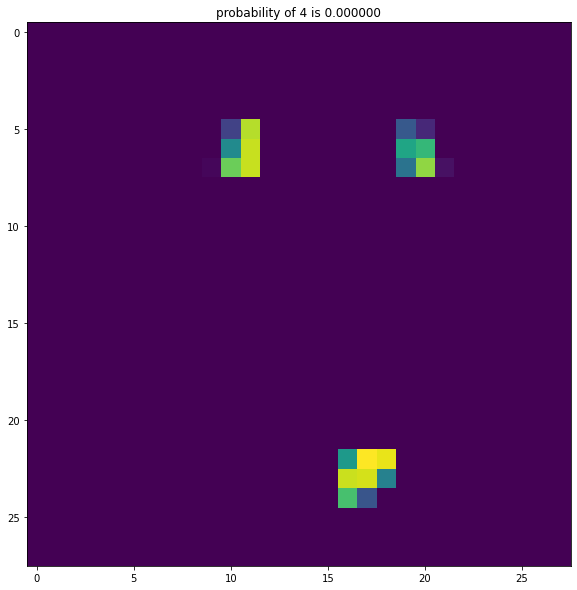

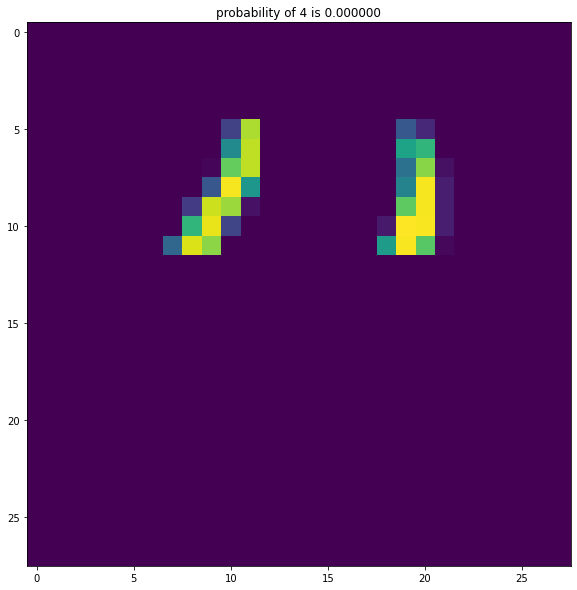

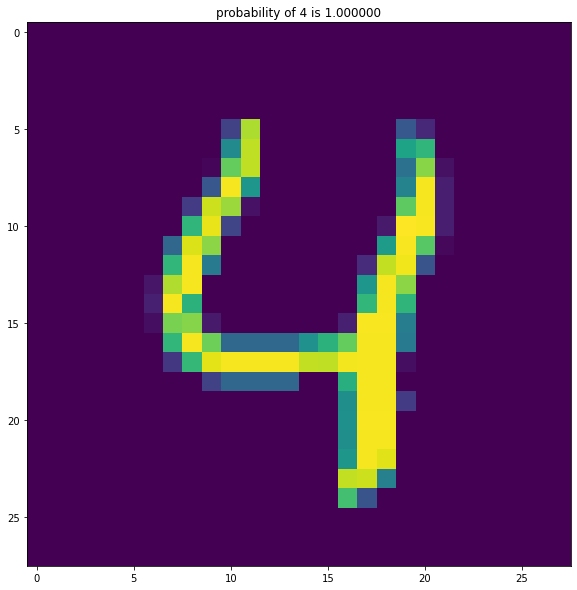

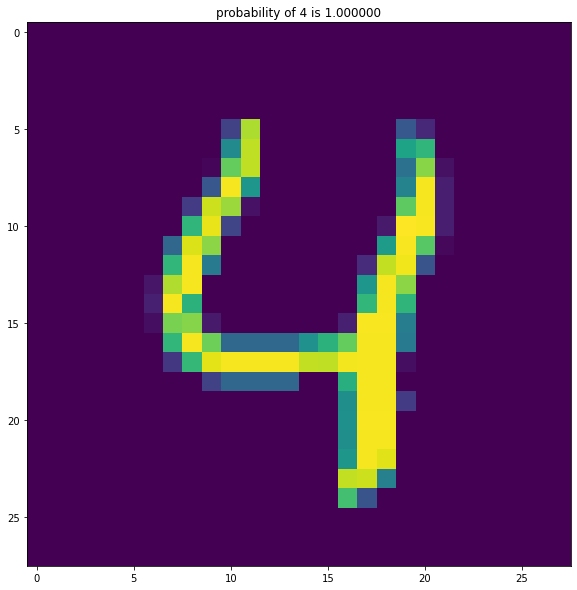

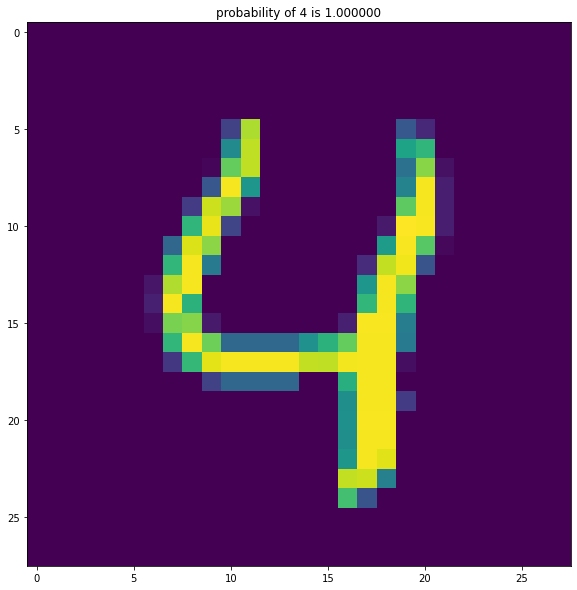

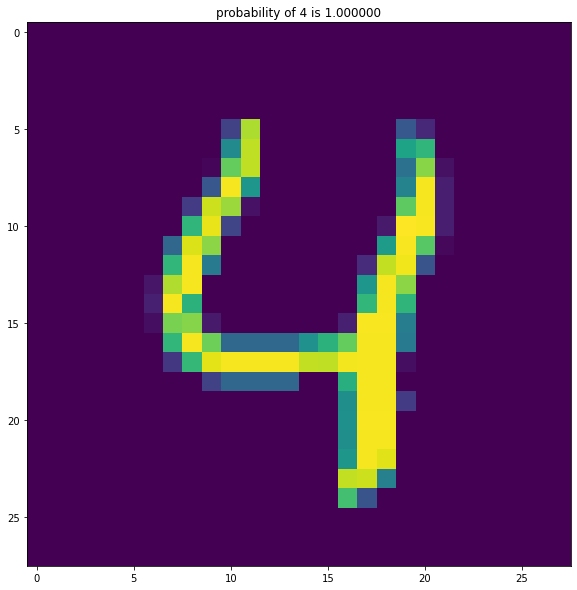

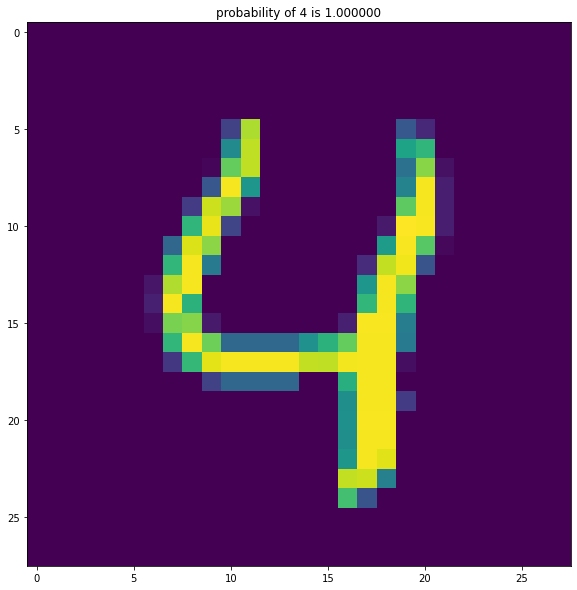

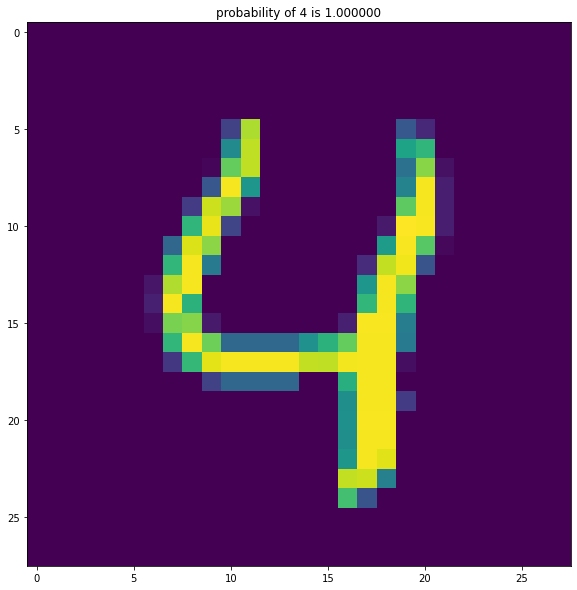

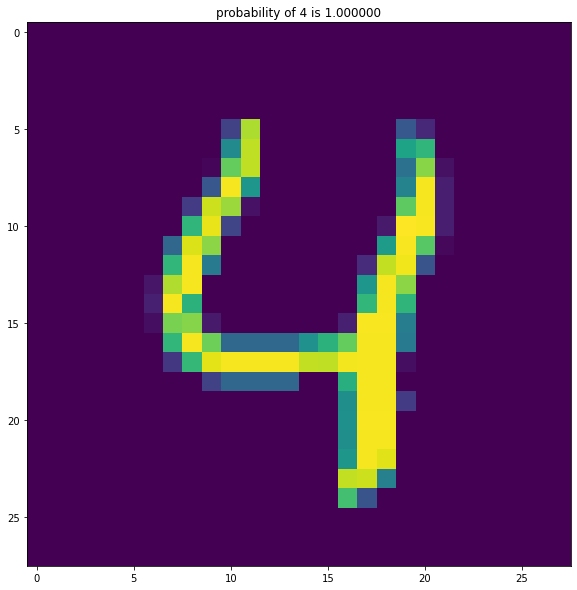

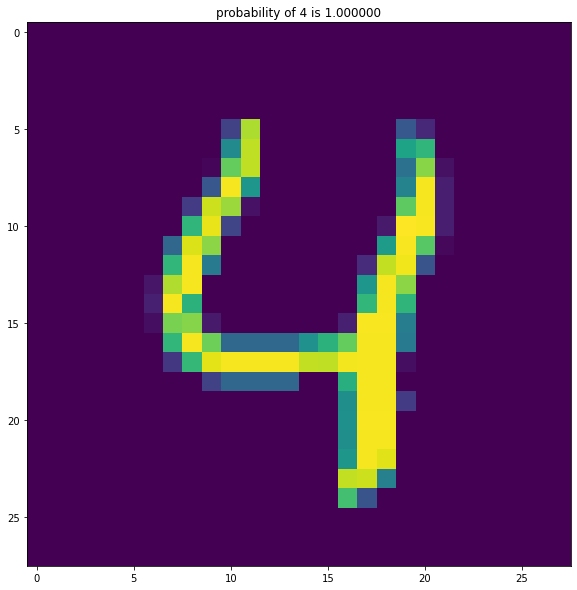

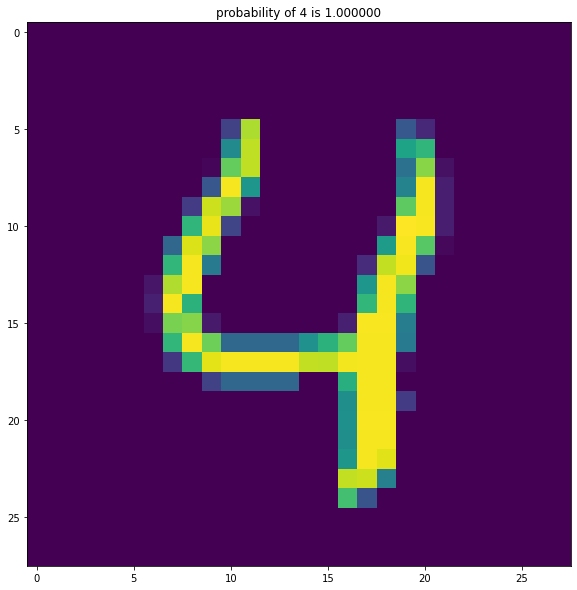

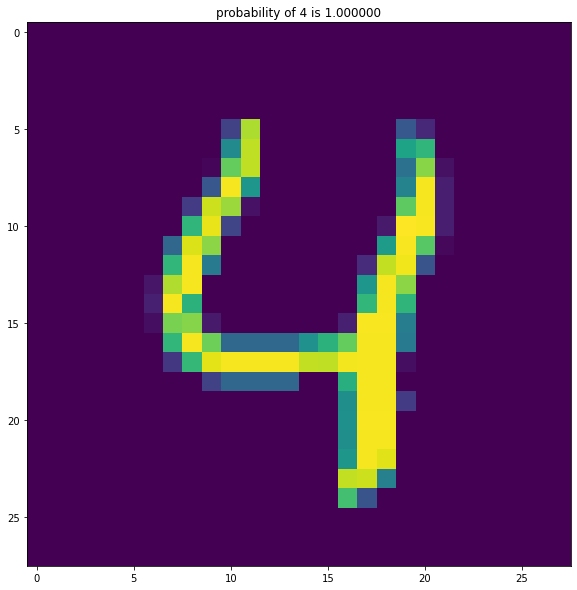

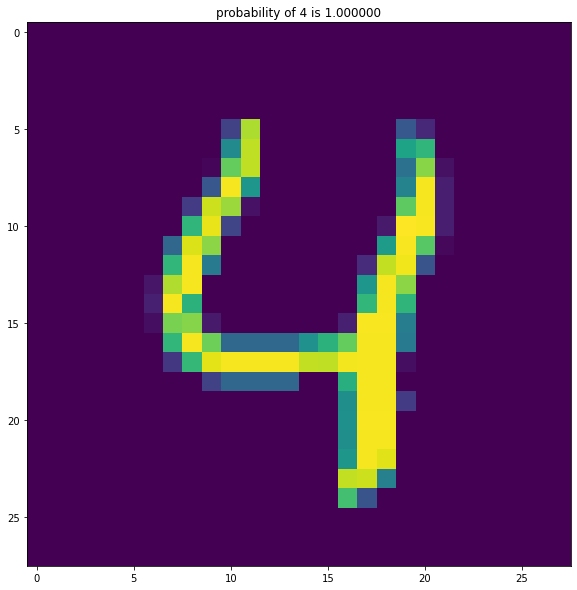

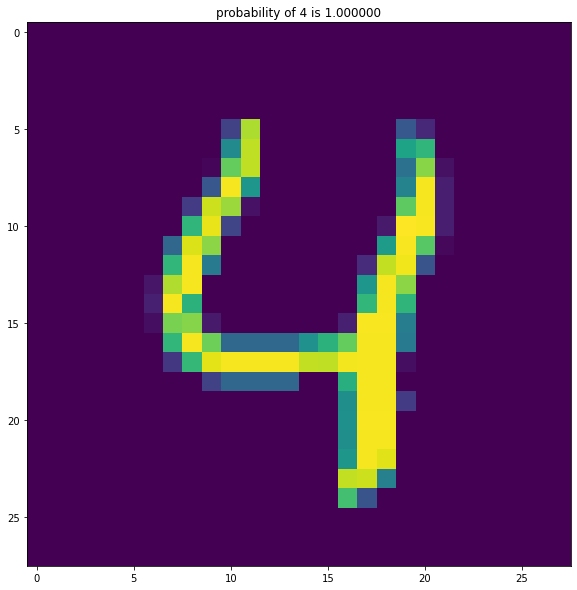


Probability of 4 as patch is move is :
[[1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]

Maximum probable class as the patch is moved is :
[[4. 4. 5. 1. 5. 7. 7.]
 [4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4.]]


In [20]:
dimension = len(range(0,14,2))
prob_map = np.zeros((dimension, dimension), dtype = float)
max_prob_class_map = np.zeros_like(prob_map)
for y in range(0,14,2):
  for x in range(0,14,2):
    temp = test_img.clone()
    temp[y:y+14, x:x+14] = 0
    with torch.no_grad():
      if(device==torch.device("cuda")):
        temp = temp.clone().reshape(1,1,28,28).cuda().float()
      else:
        temp = temp.clone().reshape(1,1,28,28).float()
      out = model.forward(temp, softmax = False)
      probab = F.softmax(out, dim=1).cpu().detach().numpy()
      prediction = np.argmax(probab)
      prob = probab[:, index]
      max_prob_class = prediction
      prob_map[int(y/2),int(x/2)] = prob[0]
      max_prob_class_map[int(y/2), int(x/2)] = max_prob_class
      if ((x%4 == 0)&(y%4==0)):
        plt.imshow(temp.cpu().numpy().reshape(28,28))
        plt.title("probability of {} is {:.6f}".format(index, prob[0]))
        plt.show()
print("\nProbability of {} as patch is move is :".format(index))
print(prob_map)
print("\nMaximum probable class as the patch is moved is :")
print(max_prob_class_map)



## *Observations:*

* For the patches at the edges the model is able to make right predictions whereas if the patch lies around the center of the image model gives wrong predicted class

____

# **Adversarial Examples**

# Non - Targetted Attack


 Input the number for which you want to generate the non targetted adversarial image	2
Adversarial Image of number: 2	  : For Iteration: 0	Logit value: [-38.10905]
Adversarial Image of number: 2	  : For Iteration: 100	Logit value: [-23.902775]
Adversarial Image of number: 2	  : For Iteration: 200	Logit value: [-9.716741]
Adversarial Image of number: 2	  : For Iteration: 300	Logit value: [4.215282]
Adversarial Image of number: 2	  : For Iteration: 400	Logit value: [17.900095]
Adversarial Image of number: 2	  : For Iteration: 500	Logit value: [32.006042]
Adversarial Image of number: 2	  : For Iteration: 600	Logit value: [46.26215]
Adversarial Image of number: 2	  : For Iteration: 700	Logit value: [60.40389]
Adversarial Image of number: 2	  : For Iteration: 800	Logit value: [74.6654]
Adversarial Image of number: 2	  : For Iteration: 900	Logit value: [88.92104]
Adversarial Image of number: 2	  : For Iteration: 1000	Logit value: [103.25814]
Adversarial Image of number: 2	  : For Iteration:

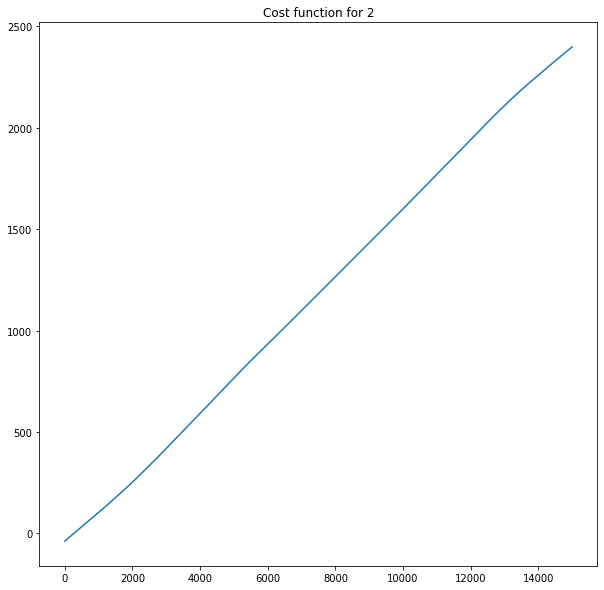

Adversarial Image of number: 2	  : For Iteration: 14999	Logit value: [2399.2395]


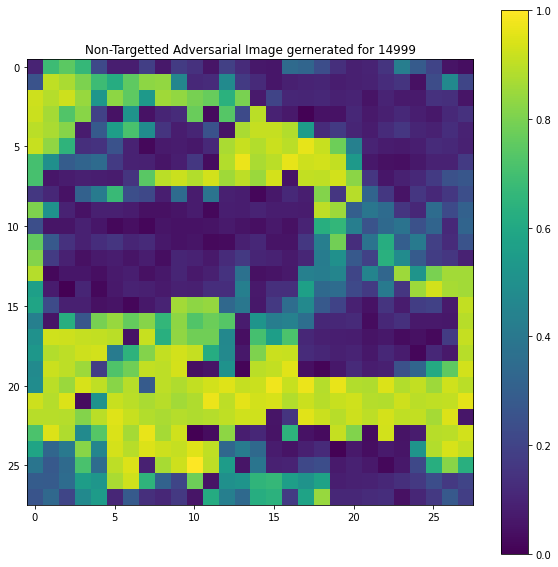

In [21]:
index = int(input("\n Input the number for which you want to generate the non targetted adversarial image\t"))
gaussian_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
if(device==torch.device("cuda")):
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).cuda().float()
else:
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).float()
logit_values = []
for i in range(non_targetted_n):
  gaussian_noise_ = torch.autograd.Variable(gaussian_noise_, requires_grad = True)
  out = model.forward(gaussian_noise_, softmax = False)
  loss = out[:, index]
  loss_index = loss.cpu().detach().numpy()
  logit_values.append(loss_index)
  if (i%100==0):
    print("Adversarial Image of number: {}\t  : For Iteration: {}\tLogit value: {}".format(index, i, loss_index))
  loss.backward(retain_graph = True)
  d = torch.sign(gaussian_noise_.grad.data)
  gaussian_noise_ = gaussian_noise_ + non_targetted_step_size*d
plt.plot(np.asfarray(logit_values))
plt.title(f"Cost function for {index}")
plt.show()

print("Adversarial Image of number: {}\t  : For Iteration: {}\tLogit value: {}".format(index, i, loss_index))
noise_kernel = gaussian_noise_.cpu().reshape(28,28).detach().numpy()
noise_kernel = noise_kernel - noise_kernel.min()
noise_kernel = noise_kernel/noise_kernel.max()
plt.imshow(noise_kernel)
plt.colorbar()
plt.title(f"Non-Targetted Adversarial Image gernerated for {i}")
plt.show()


## *Observations:*

* The cost function is always increasing
* The Adversarial Image doesnot complletely look like the original image (2) but still somehow it is a bit realisable.
* For other images also this snippet was run, and it provided similar observations


## Targetted Attack

Input the number you want to generate image to look like	3
Input the number you want the original number to be classified as	 6
Iteration: 0	 Number: 3	 Classified with probability: [0.]	 MSE: 15350.0126953125

Iteration: 20	 Number: 3	 Classified with probability: [0.]	 MSE: 15345.30078125

Iteration: 40	 Number: 3	 Classified with probability: [0.]	 MSE: 15340.4697265625

Iteration: 60	 Number: 3	 Classified with probability: [0.]	 MSE: 15336.3056640625

Iteration: 80	 Number: 3	 Classified with probability: [0.]	 MSE: 15332.5966796875

Iteration: 100	 Number: 3	 Classified with probability: [0.]	 MSE: 15328.9609375

Iteration: 120	 Number: 3	 Classified with probability: [0.]	 MSE: 15324.677734375

Iteration: 140	 Number: 3	 Classified with probability: [0.]	 MSE: 15320.29296875

Iteration: 160	 Number: 3	 Classified with probability: [0.]	 MSE: 15316.3662109375

Iteration: 180	 Number: 3	 Classified with probability: [0.]	 MSE: 15311.423828125

Iteration: 200	 Number: 3	 Classified

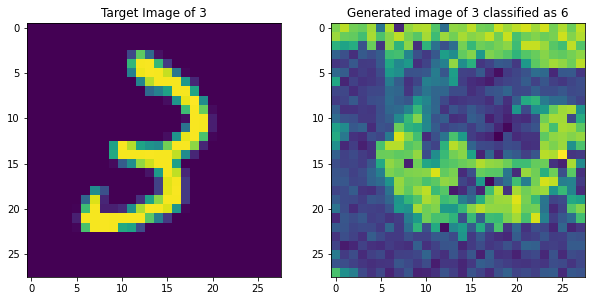

In [22]:
look_like = int(input("Input the number you want to generate image to look like\t"))
classify_as = int(input("Input the number you want the original number to be classified as\t "))
if(device==torch.device("cuda")):
  image = test_loader.dataset.data[indices[look_like], :, :].clone().reshape(1,1,28,28).cuda().float()
else:
  image = test_loader.dataset.data[indices[look_like], :, :].clone().reshape(1,1,28,28).float()  
gaussian_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
if(device==torch.device("cuda")):
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).cuda().float()
else:
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).float()
for i in range(targetted_n):
  gaussian_noise_ = torch.autograd.Variable(gaussian_noise_, requires_grad = True)
  out = model.forward(gaussian_noise_, softmax = False)
  probab = F.softmax(out, dim = 1)
  to_be_predicted_prob = probab[:,classify_as].cpu().detach().numpy()
  logit_value = out[:, classify_as]
  mse_error = F.mse_loss(gaussian_noise_, image)
  mse_error_ = mse_error.cpu().detach().numpy()
  loss = logit_value - beta*mse_error
  if (i%20==0):
    print("Iteration: {}\t Number: {}\t Classified with probability: {}\t MSE: {}\n".format(i, look_like, to_be_predicted_prob, mse_error_))
  loss.backward(retain_graph = True)
  d = torch.sign(gaussian_noise_.grad.data)
  gaussian_noise_ = gaussian_noise_ + non_targetted_step_size*d
print("Iteration: {}\t Number: {}\t Classified with probability: {}\t MSE: {}\n".format(i, look_like, to_be_predicted_prob, mse_error_))
classified_img = gaussian_noise_.cpu().reshape(28,28).detach().numpy()
classified_img = classified_img - classified_img.min()
classified_img = classified_img/classified_img.max()
f, ax = plt.subplots(1,2)
ax[0].imshow(image.cpu().reshape(28,28).numpy())
ax[0].set_title(f"Target Image of {look_like}")
ax[1].imshow(classified_img)
ax[1].set_title(f"Generated image of {look_like} classified as {classify_as}")
plt.show()

            
                
  


## *Observations:*

* Although, as per classified probability the generated image of 3 is closely classified to 6 in about 2500 iterations but still the output was not good enough and no where was close to 6, so iterations have been increased to 5000 to make a clear observation

## Adding Noise


Input the original image class	1
Input the target image class	6
Iteration: 0	 target: 6	 probability: [0.]	 Logit Value: [-120.84282]
Iteration: 5	 target: 6	 probability: [0.]	 Logit Value: [-116.45839]
Iteration: 10	 target: 6	 probability: [0.]	 Logit Value: [-112.15775]
Iteration: 15	 target: 6	 probability: [0.]	 Logit Value: [-107.888084]
Iteration: 20	 target: 6	 probability: [0.]	 Logit Value: [-103.65156]
Iteration: 25	 target: 6	 probability: [0.]	 Logit Value: [-99.45339]
Iteration: 30	 target: 6	 probability: [0.]	 Logit Value: [-95.23397]
Iteration: 35	 target: 6	 probability: [0.]	 Logit Value: [-90.99499]
Iteration: 40	 target: 6	 probability: [0.]	 Logit Value: [-86.78435]
Iteration: 45	 target: 6	 probability: [0.]	 Logit Value: [-82.5534]
Iteration: 50	 target: 6	 probability: [0.]	 Logit Value: [-78.32528]
Iteration: 55	 target: 6	 probability: [0.]	 Logit Value: [-74.09195]
Iteration: 60	 target: 6	 probability: [0.]	 Logit Value: [-69.906425]
Iteration: 65	 target:

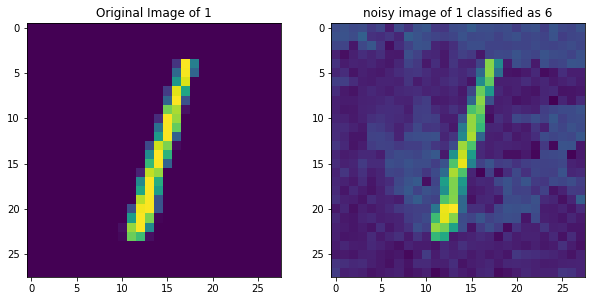


Input the number to which you want to add noise	8


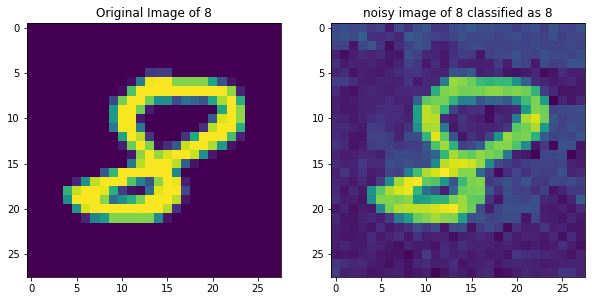

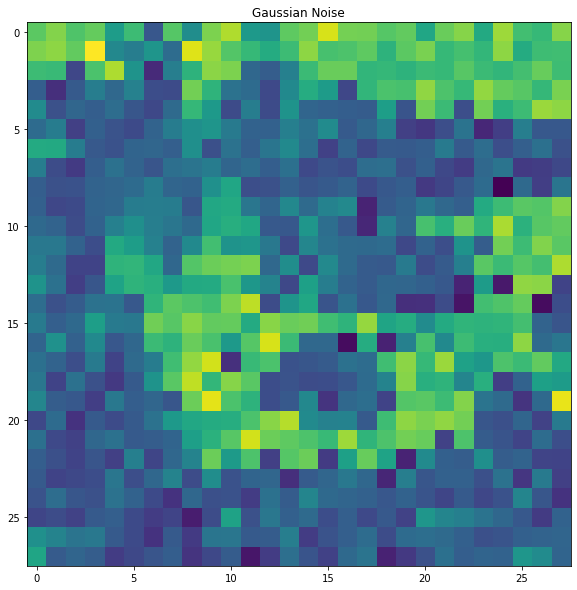

In [36]:
orig_input = int(input("Input the original image class\t"))
target_input = int(input("Input the target image class\t"))
if(device==torch.device("cuda")):
  image = test_loader.dataset.data[indices[orig_input], :, :].clone().reshape(1,1,28,28).cuda().float()
else:
  image = test_loader.dataset.data[indices[orig_input], :, :].clone().reshape(1,1,28,28).float()  
gaussian_noise = np.random.normal(loc = 128, scale = 10, size = (28,28))
if(device==torch.device("cuda")):
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).cuda().float()
else:
  gaussian_noise_ = torch.from_numpy(gaussian_noise).reshape(1,1,28,28).float()
prob = 0
highest_prob = orig_input
iter = 0
while(highest_prob!=target_input):
  gaussian_noise_ = torch.autograd.Variable(gaussian_noise_, requires_grad = True)
  out = model.forward(gaussian_noise_, softmax = False)
  probab = F.softmax(out, dim = 1).cpu().detach().numpy()
  highest_prob = int(np.argmax(probab))
  prob = probab[:, target_input]
  loss = out[:, target_input]
  loss_op = loss.cpu().detach().numpy()
  if (iter%5==0):
    print("Iteration: {}\t target: {}\t probability: {}\t Logit Value: {}".format(iter, target_input, prob, loss_op))
  loss.backward(retain_graph = True)
  d = torch.sign(gaussian_noise_.grad.data)
  d = d - d.min()
  d = d/d.max()
  gaussian_noise_ = gaussian_noise_ + alpha*d
  iter = iter+1

print("Iteration: {}\t target: {}\t probability: {}\t Logit Value: {}".format(iter, target_input, prob, loss_op))
noisy_image = (gaussian_noise_ + image).cpu().reshape(28,28).detach().numpy()
noisy_image = noisy_image - noisy_image.min()
noisy_image = noisy_image/noisy_image.max()
f, ax = plt.subplots(1,2)
ax[0].imshow(image.cpu().reshape(28,28).numpy())
ax[0].set_title(f"Original Image of {orig_input}")
ax[1].imshow(noisy_image)
ax[1].set_title(f"noisy image of {orig_input} classified as {target_input}")
plt.show()

new_input = int(input("\nInput the number to which you want to add noise\t"))
if(device==torch.device("cuda")):
  image = test_loader.dataset.data[indices[new_input], :, :].clone().reshape(1,1,28,28).cuda().float()
else:
  new_image = test_loader.dataset.data[indices[new_input], :, :].clone().reshape(1,1,28,28).float()  
out = model.forward(gaussian_noise_ + new_image, softmax = False)
probab = F.softmax(out, dim = 1).cpu().detach().numpy()
highest_prob = int(np.argmax(probab))
prob = probab[:, highest_prob]

noisy_image = (gaussian_noise_ + new_image).cpu().reshape(28,28).detach().numpy()
noisy_image = noisy_image - noisy_image.min()
noisy_image = noisy_image/noisy_image.max()
f, ax = plt.subplots(1,2)
ax[0].imshow(new_image.cpu().reshape(28,28).numpy())
ax[0].set_title(f"Original Image of {new_input}")
ax[1].imshow(noisy_image)
ax[1].set_title(f"noisy image of {new_input} classified as {highest_prob}")
plt.show()

#Displaying the Gaussian Noise
gaussian = (gaussian_noise_).cpu().reshape(28,28).detach().numpy()
gaussian = gaussian - np.min(gaussian)
gaussian = gaussian/np.max(gaussian)
plt.imshow(gaussian)
plt.title(f"Gaussian Noise")
plt.show()


## *Observations:*

* The iterations run till the target class gets highest probability
* First Plot is of the original image with noise added to it to classify it as another number
* Second plot shows behaviour of a new class image on noise being added to it
* Third plot is the noise kernel